## **IMPORTS**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

## **PATHS**

In [18]:
file_path = r"C:\Users\elifr\OneDrive\Desktop\PROJECTS\Proje101\close_prices.csv"


In [19]:
def read_stock_data(file_path):

    try:
        df = pd.read_csv(file_path)
        
        if 'Date' in df.columns or df.columns[0].lower() in ['date', 'time', 'period']:
            date_col = 'Date' if 'Date' in df.columns else df.columns[0]
            df.set_index(date_col, inplace=True)
            
        return df
    except Exception as e:
        print(f"Error reading file: {e}")
        raise

## **CREATE EQUALLY-WEIGHTED & RANDOM-WEIGHTED PORTFOLIOS**

In [20]:
def create_equal_weight_portfolio(stock_names):

    if not stock_names or len(stock_names) == 0:
        raise ValueError("Stock names list cannot be empty")
    
    equal_weight = 1.0 / len(stock_names)
    weights = {stock: equal_weight for stock in stock_names}
    
    return {
        'stocks': stock_names,
        'weights': weights
    }

def create_random_weight_portfolio(stock_names):

    if not stock_names or len(stock_names) == 0:
        raise ValueError("Stock names list cannot be empty")
    
    random_numbers = np.random.random(len(stock_names))
    
    # SUM(weights) = 1
    normalized_weights = random_numbers / np.sum(random_numbers) 
    
    # Create weights dictionary
    weights = {stock: weight for stock, weight in zip(stock_names, normalized_weights)}
    
    return {
        'stocks': stock_names,
        'weights': weights
    }

## **STATISTICS - MEASUREMENTS**

In [21]:
def get_stock_sectors():

    stocks_by_sector = {
        "Technology": ["AAPL", "MSFT", "NVDA", "GOOGL"],
        "Healthcare": ["JNJ", "PFE", "UNH", "MRNA"],
        "Financials": ["JPM", "BAC", "GS", "V"],
        "Consumer Discretionary": ["AMZN", "TSLA", "NKE", "MCD"],
        "Consumer Staples": ["PG", "KO", "WMT", "UL"],
        "Energy": ["XOM", "CVX", "BP", "NEE"],
        "Industrials": ["GE", "CAT", "BA", "HON"],
        "Utilities": ["DUK", "SO"],
        "Real Estate": ["AMT", "SPG", "O"],
        "Materials": ["FCX", "DOW", "LIN"]
    }
    
    # Create a reverse mapping: stock -> sector
    stock_to_sector = {}
    for sector, stocks in stocks_by_sector.items():
        for stock in stocks:
            stock_to_sector[stock] = sector
            
    return stock_to_sector

def calculate_portfolio_metrics(portfolio, price_data, risk_free_rate=0.02):
    """
    portfolio (dict): Portfolio dictionary with 'stocks' and 'weights' keys

    Returns:
    dict: Dictionary with calculated metrics
    """

    stocks = portfolio['stocks']
    weights = portfolio['weights']
    
    available_stocks = [stock for stock in stocks if stock in price_data.columns]
    
    if not available_stocks:
        raise ValueError("None of the portfolio stocks are in the provided data")
    
    filtered_weights = {stock: weights[stock] for stock in available_stocks}
    weight_sum = sum(filtered_weights.values())
    normalized_weights = {k: v/weight_sum for k, v in filtered_weights.items()}
    
    portfolio_prices = price_data[available_stocks]
    
    returns = np.log(portfolio_prices / portfolio_prices.shift(1)).dropna()

    # Calculate weighted returns
    weighted_returns = pd.DataFrame()
    for stock in available_stocks:
        weighted_returns[stock] = returns[stock] * normalized_weights[stock]
    
    # Calculate portfolio daily return
    portfolio_return = weighted_returns.sum(axis=1)
    
    # Calculate metrics
    if len(portfolio_return) == 0:
        return {
            "total_return": 0,
            "annual_return": 0,
            "sharpe_ratio": 0,
            "treynor_ratio": 0,
            "num_assets": len(available_stocks),
            "max_weight_stock": ("N/A", 0),
            "max_weight_sector": ("N/A", 0),
            "volatility": 0,
            "beta": 0
        }
    
    total_return = (1 + portfolio_return).prod() - 1
    annual_return = (1 + total_return) ** (252 / len(portfolio_return)) - 1
    daily_rf_rate = (1 + risk_free_rate) ** (1/252) - 1
    excess_return = portfolio_return - daily_rf_rate
    sharpe_ratio = excess_return.mean() / portfolio_return.std() * np.sqrt(252) if portfolio_return.std() > 0 else 0
    
    # beta
    # Using a simple market proxy (equally weighted market of all stocks)
    market_return = returns.mean(axis=1)
    portfolio_beta = portfolio_return.cov(market_return) / market_return.var()
    
    # Treynor ratio
    treynor_ratio = (annual_return - risk_free_rate) / portfolio_beta if portfolio_beta != 0 else np.nan
    
    # stock with highest weight
    max_weight_stock = max(normalized_weights.items(), key=lambda x: x[1])
    
    # sector with highest weight
    stock_to_sector = get_stock_sectors()
    sector_weights = {}
    for stock, weight in normalized_weights.items():
        sector = stock_to_sector.get(stock, "Unknown")
        sector_weights[sector] = sector_weights.get(sector, 0) + weight
    
    max_weight_sector = max(sector_weights.items(), key=lambda x: x[1]) if sector_weights else ("Unknown", 0)
    
    return {
        "total_return": total_return,
        "annual_return": annual_return,
        "sharpe_ratio": sharpe_ratio,
        "treynor_ratio": treynor_ratio,
        "num_assets": len(available_stocks),
        "max_weight_stock": max_weight_stock,
        "max_weight_sector": max_weight_sector,
        "volatility": portfolio_return.std() * np.sqrt(252),
        "beta": portfolio_beta
    }


## **COMPARE GIVEN PORTFOLIOS**

In [22]:
def compare_portfolios(portfolio1, portfolio2, price_data_path, risk_free_rate=0.02):
    """
    portfolio1 & 2 (dict): portfolio dictionaries with 'stocks' and 'weights' keys
    
    Returns:
    dict: Dictionary with comparison results
    """
    price_data = read_stock_data(price_data_path)
    
    metrics1 = calculate_portfolio_metrics(portfolio1, price_data, risk_free_rate)
    metrics2 = calculate_portfolio_metrics(portfolio2, price_data, risk_free_rate)
    
    # comparison format
    comparison = {
        "Portfolio 1": {
            "Total Return": f"{metrics1['total_return']:.4f}",
            "Annual Return": f"{metrics1['annual_return']:.4f}",
            "Sharpe Ratio": f"{metrics1['sharpe_ratio']:.4f}",
            "Treynor Ratio": f"{metrics1['treynor_ratio']:.4f}" if not np.isnan(metrics1['treynor_ratio']) else "N/A",
            "Number of Assets": metrics1['num_assets'],
            "Highest Weight Stock": f"{metrics1['max_weight_stock'][0]} ({metrics1['max_weight_stock'][1]:.4f})",
            "Highest Weight Sector": f"{metrics1['max_weight_sector'][0]} ({metrics1['max_weight_sector'][1]:.4f})",
            "Volatility (Annual)": f"{metrics1['volatility']:.4f}",
            "Beta": f"{metrics1['beta']:.4f}"
        },
        "Portfolio 2": {
            "Total Return": f"{metrics2['total_return']:.4f}",
            "Annual Return": f"{metrics2['annual_return']:.4f}",
            "Sharpe Ratio": f"{metrics2['sharpe_ratio']:.4f}",
            "Treynor Ratio": f"{metrics2['treynor_ratio']:.4f}" if not np.isnan(metrics2['treynor_ratio']) else "N/A",
            "Number of Assets": metrics2['num_assets'],
            "Highest Weight Stock": f"{metrics2['max_weight_stock'][0]} ({metrics2['max_weight_stock'][1]:.4f})",
            "Highest Weight Sector": f"{metrics2['max_weight_sector'][0]} ({metrics2['max_weight_sector'][1]:.4f})",
            "Volatility (Annual)": f"{metrics2['volatility']:.4f}",
            "Beta": f"{metrics2['beta']:.4f}"
        },
        "Comparison": {
            "Better Total Return": "Portfolio 1" if metrics1['total_return'] > metrics2['total_return'] else "Portfolio 2",
            "Better Sharpe Ratio": "Portfolio 1" if metrics1['sharpe_ratio'] > metrics2['sharpe_ratio'] else "Portfolio 2",
            "Better Treynor Ratio": "Portfolio 1" if metrics1['treynor_ratio'] > metrics2['treynor_ratio'] else "Portfolio 2",
            "More Diversified": "Portfolio 1" if metrics1['num_assets'] > metrics2['num_assets'] else "Portfolio 2",
            "Lower Volatility": "Portfolio 1" if metrics1['volatility'] < metrics2['volatility'] else "Portfolio 2"
        }
    }
    
    return comparison

In [23]:
def visualize_portfolio_comparison(portfolio1, portfolio2, price_data_path, risk_free_rate=0.02):

    comparison_results = compare_portfolios(portfolio1, portfolio2, price_data_path, risk_free_rate)
    
    price_data = read_stock_data(price_data_path)
    
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(2, 3, figure=fig)
    
    # 1. Key Metrics Comparison (First subplot)
    ax1 = fig.add_subplot(gs[0, 0])
    metrics = ['Total Return', 'Annual Return', 'Sharpe Ratio', 'Volatility (Annual)']
    
    p1_metrics = [float(comparison_results['Portfolio 1'][m]) for m in metrics]
    p2_metrics = [float(comparison_results['Portfolio 2'][m]) for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax1.bar(x - width/2, p1_metrics, width, label='Portfolio 1')
    ax1.bar(x + width/2, p2_metrics, width, label='Portfolio 2')
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics, rotation=45, ha='right')
    ax1.set_title('Key Performance Metrics')
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 2. Composition - Pie charts (Second subplot)
    # Portfolio 1 weights
    ax2 = fig.add_subplot(gs[0, 1])
    p1_labels = list(portfolio1['weights'].keys())
    p1_sizes = list(portfolio1['weights'].values())
    
    ax2.pie(p1_sizes, labels=p1_labels, autopct='%1.1f%%', startangle=90)
    ax2.axis('equal')
    ax2.set_title('Portfolio 1 Composition')
    
    # Portfolio 2 weights
    ax3 = fig.add_subplot(gs[0, 2])
    p2_labels = list(portfolio2['weights'].keys())
    p2_sizes = list(portfolio2['weights'].values())
    
    ax3.pie(p2_sizes, labels=p2_labels, autopct='%1.1f%%', startangle=90)
    ax3.axis('equal')
    ax3.set_title('Portfolio 2 Composition')
    
    # 3. Cumulative Return over time
    ax4 = fig.add_subplot(gs[1, :2])
    
    # Calculate cumulative returns for both portfolios
    # Portfolio 1
    p1_stocks = [stock for stock in portfolio1['stocks'] if stock in price_data.columns]
    p1_weights = {k: v for k, v in portfolio1['weights'].items() if k in p1_stocks}
    p1_weight_sum = sum(p1_weights.values())
    p1_norm_weights = {k: v/p1_weight_sum for k, v in p1_weights.items()}
    
    # Portfolio 2
    p2_stocks = [stock for stock in portfolio2['stocks'] if stock in price_data.columns]
    p2_weights = {k: v for k, v in portfolio2['weights'].items() if k in p2_stocks}
    p2_weight_sum = sum(p2_weights.values())
    p2_norm_weights = {k: v/p2_weight_sum for k, v in p2_weights.items()}
    
    # Calculate daily returns
    returns = price_data.pct_change().dropna()
    
    # Calculate weighted returns for Portfolio 1
    p1_weighted_returns = pd.DataFrame()
    for stock in p1_stocks:
        if stock in returns.columns:
            p1_weighted_returns[stock] = returns[stock] * p1_norm_weights[stock]
    
    # Calculate weighted returns for Portfolio 2
    p2_weighted_returns = pd.DataFrame()
    for stock in p2_stocks:
        if stock in returns.columns:
            p2_weighted_returns[stock] = returns[stock] * p2_norm_weights[stock]
    
    # Calculate portfolio daily returns
    p1_daily_return = p1_weighted_returns.sum(axis=1)
    p2_daily_return = p2_weighted_returns.sum(axis=1)
    
    # Calculate cumulative returns
    p1_cumulative = (1 + p1_daily_return).cumprod()
    p2_cumulative = (1 + p2_daily_return).cumprod()
    
    # Plot cumulative returns
    ax4.plot(p1_cumulative.index, p1_cumulative, label='Portfolio 1')
    ax4.plot(p2_cumulative.index, p2_cumulative, label='Portfolio 2')
    ax4.set_title('Cumulative Return Over Time')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Cumulative Return')
    ax4.legend()
    ax4.grid(True, linestyle='--', alpha=0.7)
    
    # 4. Comparison Summary (Text in the last subplot)
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.axis('off')
    
    summary_text = "Comparison Summary:\n\n"
    for metric, winner in comparison_results['Comparison'].items():
        summary_text += f"{metric}: {winner}\n"
    
    # Add additional metrics
    p1_max_stock = comparison_results['Portfolio 1']['Highest Weight Stock']
    p2_max_stock = comparison_results['Portfolio 2']['Highest Weight Stock']
    p1_max_sector = comparison_results['Portfolio 1']['Highest Weight Sector']
    p2_max_sector = comparison_results['Portfolio 2']['Highest Weight Sector']
    
    summary_text += f"\nPortfolio 1 Details:\n"
    summary_text += f"Number of Assets: {comparison_results['Portfolio 1']['Number of Assets']}\n"
    summary_text += f"Highest Weight Stock: {p1_max_stock}\n"
    summary_text += f"Highest Weight Sector: {p1_max_sector}\n"
    summary_text += f"Beta: {comparison_results['Portfolio 1']['Beta']}\n"
    
    summary_text += f"\nPortfolio 2 Details:\n"
    summary_text += f"Number of Assets: {comparison_results['Portfolio 2']['Number of Assets']}\n"
    summary_text += f"Highest Weight Stock: {p2_max_stock}\n"
    summary_text += f"Highest Weight Sector: {p2_max_sector}\n"
    summary_text += f"Beta: {comparison_results['Portfolio 2']['Beta']}\n"
    
    ax5.text(0, 1, summary_text, fontsize=10, va='top')
    
    plt.tight_layout()
    return fig

Available stocks in the data: ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'JNJ', 'PFE', 'UNH', 'MRNA', 'JPM', 'BAC', 'GS', 'V', 'AMZN', 'TSLA', 'NKE', 'MCD', 'PG', 'KO', 'WMT', 'UL', 'XOM', 'CVX', 'BP', 'NEE', 'GE', 'CAT', 'BA', 'HON', 'DUK', 'SO', 'AMT', 'SPG', 'O', 'FCX', 'DOW', 'LIN']

----------------------------------- PORTFOLIO1: -----------------------------------
Portfolio 1 stocks: ['AAPL', 'MSFT', 'NVDA', 'GOOGL']

----------------------------------- PORTFOLIO2: -----------------------------------
Portfolio 2 stocks: ['AAPL', 'JNJ', 'JPM', 'AMZN', 'PG', 'XOM', 'GE', 'DUK']

----------------------------------- PORTFOLIO COMPARISON: -----------------------------------
Portfolio 1 (Equal Weight):
  Total Return: 1.3396
  Annual Return: 0.5374
  Sharpe Ratio: 1.8852
  Treynor Ratio: 0.5174
  Number of Assets: 4
  Highest Weight Stock: AAPL (0.2500)
  Highest Weight Sector: Technology (1.0000)
  Volatility (Annual): 0.2321
  Beta: 1.0000

Portfolio 2 (Random Weight):
  Total Return: 0.5754


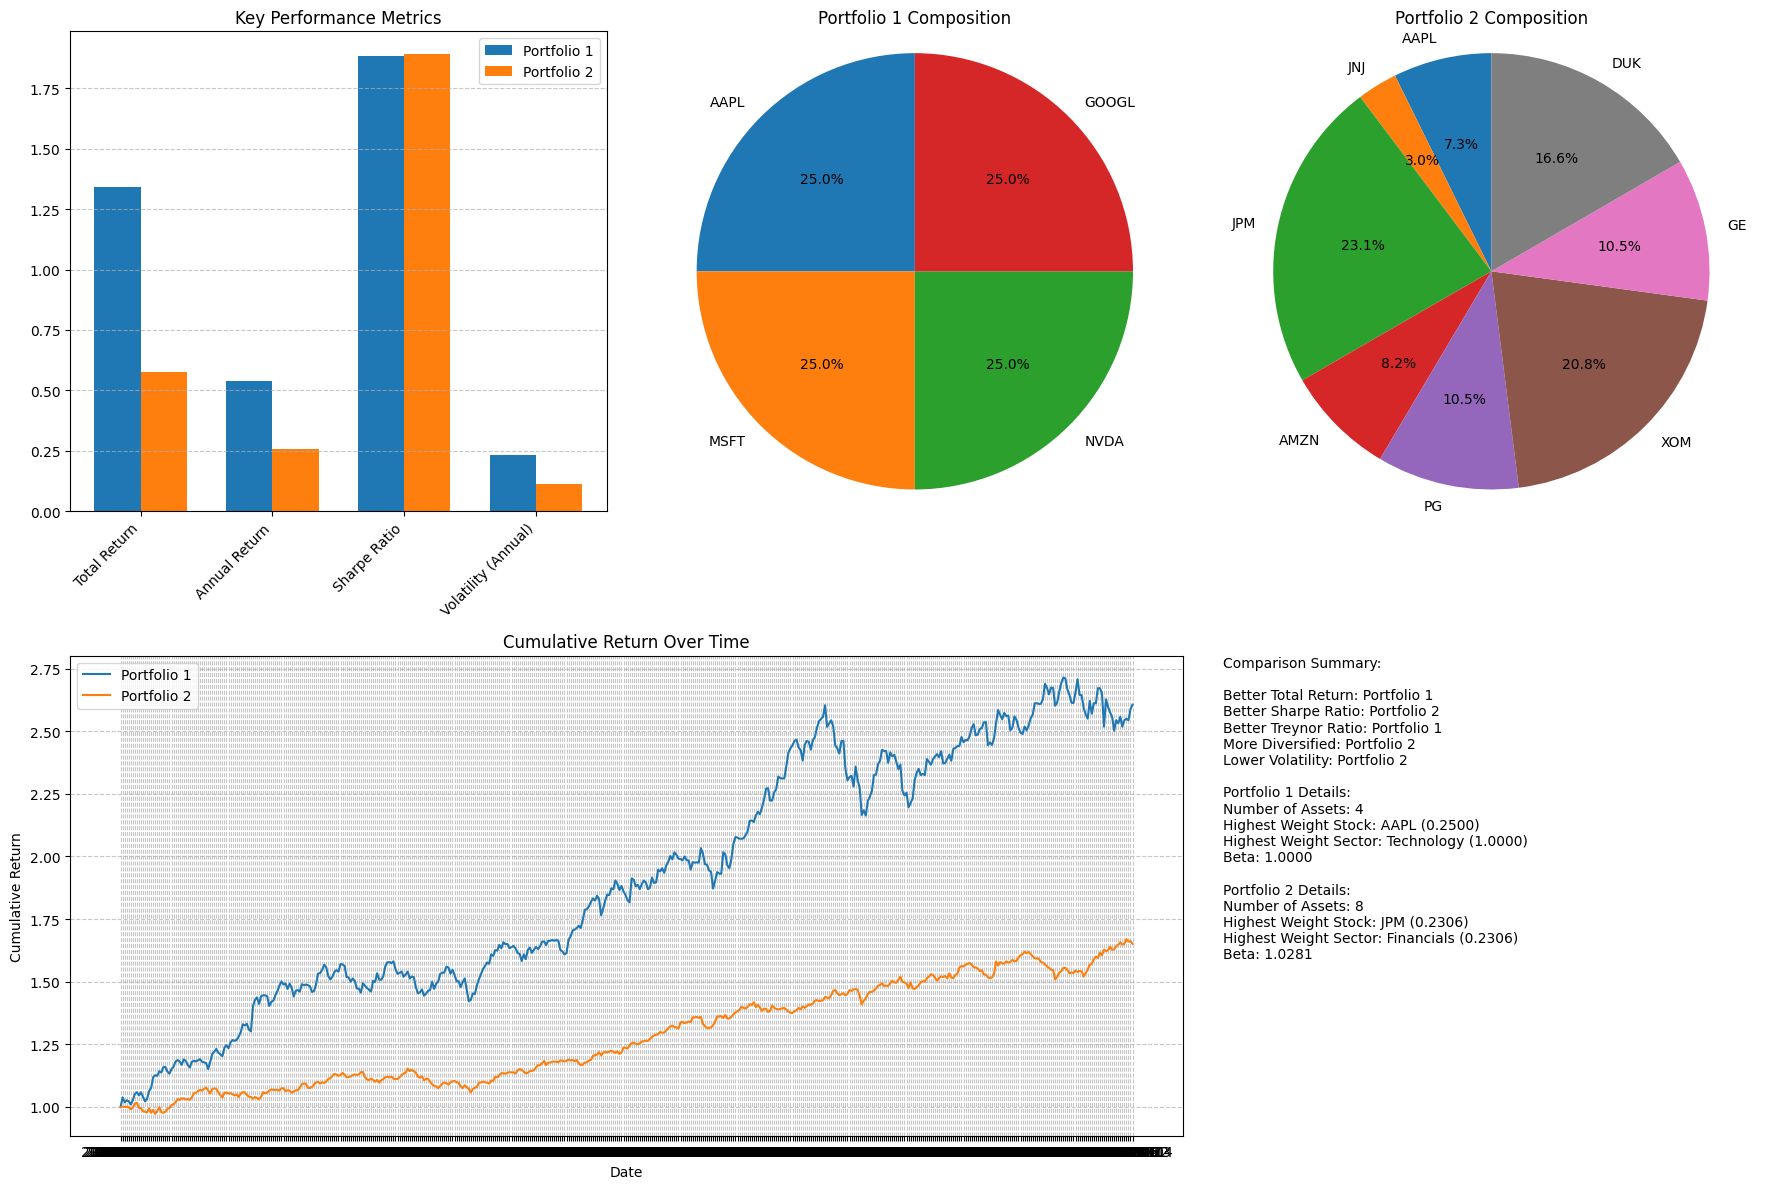

Visualization completed and saved at, portfolio_comparison.png


In [27]:
stock_data = read_stock_data(file_path)
available_stocks = stock_data.columns.tolist()

print(f"Available stocks in the data: {available_stocks}")
print()


print("-" * 35,"PORTFOLIO1:","-" * 35)

tech_stocks = [stock for stock in ["AAPL", "MSFT", "NVDA", "GOOGL"] if stock in available_stocks]
portfolio1 = create_equal_weight_portfolio(tech_stocks)
print(f"Portfolio 1 stocks: {tech_stocks}")
print()


print("-" * 35,"PORTFOLIO2:","-" * 35)

diverse_stocks = [stock for stock in ["AAPL", "JNJ", "JPM", "AMZN", "PG", "XOM", "GE", "DUK"] if stock in available_stocks]
portfolio2 = create_random_weight_portfolio(diverse_stocks)
print(f"Portfolio 2 stocks: {diverse_stocks}")
print()


print("-" * 35,"PORTFOLIO COMPARISON:","-" * 35)

comparison_result = compare_portfolios(portfolio1, portfolio2, file_path)

print("Portfolio 1 (Equal Weight):")
for metric, value in comparison_result["Portfolio 1"].items():
    print(f"  {metric}: {value}")
print()

print("Portfolio 2 (Random Weight):")
for metric, value in comparison_result["Portfolio 2"].items():
    print(f"  {metric}: {value}")
print()

print("Comparison Summary:")
for metric, better_portfolio in comparison_result["Comparison"].items():
    print(f"  {metric}: {better_portfolio}")
print()

fig = visualize_portfolio_comparison(portfolio1, portfolio2, file_path)

png_path = "portfolio_comparison.png"
plt.savefig(png_path, dpi=300, bbox_inches='tight')
plt.show()

print("Visualization completed and saved at,", png_path)